##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Text classification with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/text_classification_rnn"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This text classification tutorial trains a [recurrent neural network](https://developers.google.com/machine-learning/glossary/#recurrent_neural_network) on the [IMDB large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) for sentiment analysis.

## Setup

In [2]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()
np.set_printoptions(precision=3, suppress=True)

Import `matplotlib` and create a helper function to plot graphs:

In [3]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets). See the [loading text tutorial](https://www.tensorflow.org/tutorials/load_data/text) for details on how to load this sort of data manually.


[4163, 20620]


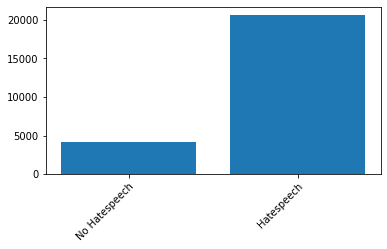

<Figure size 1152x720 with 0 Axes>

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


#
# Load the csv data.
#
def load_data_arrays():
    data_path = "datasets/1_no_stopwords.csv"
    df = pd.read_csv(data_path)

    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True, stratify=df["is_hatespeech"])
    
    return train_df, test_df

def plot_data_distribution(labels_1, label_2):
    total = labels_1.reshape(-1).tolist()
    total.extend(label_2.reshape(-1).tolist())
    bins = sorted(list(set(total)))

    plt.bar(bins, [total.count(bin_val) for bin_val in bins])
    print([total.count(bin_val) for bin_val in bins])
    plt.xticks(bins,
               ["No Hatespeech", "Hatespeech"],
               rotation=45,
               rotation_mode="anchor",
               ha="right")

    plt.subplots_adjust(bottom=0.3)
    plt.figure(figsize=(16, 10))
    plt.show()

train_df, test_df = load_data_arrays()


plot_data_distribution(train_df['is_hatespeech'].values, test_df['is_hatespeech'].values)

In [5]:
# Convert the test- and train-DataFrames to Tensorflow Datasets

train_labels = np.eye(2)[train_df['is_hatespeech'].values]
train_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(np.asarray(train_df['text'].values, dtype=str), tf.string),
            tf.cast(train_labels, tf.int32)
        )
    )
)

test_labels = np.eye(2)[test_df['is_hatespeech'].values]
test_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(np.asarray(test_df['text'].values, dtype=str), tf.string),
            tf.cast(test_labels, tf.int32)
        )
    )
)

Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [6]:
BUFFER_SIZE = 1000
BATCH_SIZE = 64

In [7]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [8]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy())
  print()
  print('labels: ', label.numpy())

texts:  [b'what fucking retard'
 b'southwest airlines like driving mini van white trash cousins love huff paint thinner working'
 b'then bitches gon fuck money long'
 b'okay bitch tomorrow principals office be there'
 b'messy asss bitches i would blast yall dumb bitches im even gon stoop yalls level'
 b'never keep leeches life if bitches take give time cut'
 b'lawd i got many enemies bitches i even know'
 b'gay fuck busted basic bitches lol'
 b'my fantasy reign starts today got pussy nigga los first lmaocmon seattle d cut upppppp'
 b'rt mariano rivera street outside yankee stadium named him giants also similar honors'
 b'bitch finna get crunk eyebrows double papp'
 b'rt 6 god drake trash thank'
 b'floyd please deliver temptation i oh wish bitch would hurry thee fuck i surfboard bed'
 b'rt flappy bird deep hahaha' b'tounge punching smelly turtle pussy'
 b'nigga said i woke bed fulla bitches i aint een fuckin idc shit bout 10x harder'
 b'ol bitch ass look like got bobble head' b'rt riff 

## Create the text encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [9]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency: 

In [10]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'bitch', 'rt', 'i', 'bitches', 'like', 'hoes', 'im',
       'pussy', 'hoe', 'ass', 'fuck', 'get', 'shit', 'got', 'u', 'you',
       'nigga', 'aint'], dtype='<U27')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [11]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[114,  29, 276,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0],
       [  1,   1,   6,   1,   1,   1,  69,  20,   1,  26,   1,   1,   1,
        676,   0,   0,   0,   0,   0,   0,   0],
       [436,   5, 229,  12, 104, 268,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0]], dtype=int64)

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [12]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'what fucking retard'
Round-trip:  what fucking retard                  

Original:  b'southwest airlines like driving mini van white trash cousins love huff paint thinner working'
Round-trip:  [UNK] [UNK] like [UNK] [UNK] [UNK] white trash [UNK] love [UNK] [UNK] [UNK] working       

Original:  b'then bitches gon fuck money long'
Round-trip:  then bitches gon fuck money long               



## Create the model

Above is a diagram of the model. 

1. This model can be build as a `tf.keras.Sequential`.

2. The first layer is the `encoder`, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

4. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output. 

  * The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

5. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output. 


The code to implement this is below:

In [13]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          64000     
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 138,434
Trainable params: 138,434
Non-trai

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [14]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [15]:
# predict on a sample text without padding.

sample_text = ('How are you doing')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[0.498 0.502]


Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [16]:
# predict on a sample text with padding

padding = "How are you doing " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[0.498 0.502]


Compile the Keras model to configure the training process:

In [17]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics=['accuracy'])

## Train the model

In [18]:
history = model.fit(train_dataset, epochs=5,
                    validation_data=test_dataset,
                    validation_steps=10)

Epoch 1/5
310/310 [==============================] - 6s 10ms/step - loss: 0.4681 - accuracy: 0.8359 - f1_score: 0.8359 - val_loss: 0.2611 - val_accuracy: 0.8766 - val_f1_score: 0.8766
Epoch 2/5
310/310 [==============================] - 2s 6ms/step - loss: 0.1824 - accuracy: 0.9263 - f1_score: 0.9263 - val_loss: 0.1538 - val_accuracy: 0.9312 - val_f1_score: 0.9312
Epoch 3/5
310/310 [==============================] - 2s 6ms/step - loss: 0.1308 - accuracy: 0.9484 - f1_score: 0.9484 - val_loss: 0.1482 - val_accuracy: 0.9391 - val_f1_score: 0.9391
Epoch 4/5
310/310 [==============================] - 2s 6ms/step - loss: 0.1166 - accuracy: 0.9559 - f1_score: 0.9559 - val_loss: 0.1483 - val_accuracy: 0.9453 - val_f1_score: 0.9453
Epoch 5/5
310/310 [==============================] - 2s 6ms/step - loss: 0.1100 - accuracy: 0.9588 - f1_score: 0.9588 - val_loss: 0.1535 - val_accuracy: 0.9391 - val_f1_score: 0.9391


In [19]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

78/78 [==============================] - 0s 2ms/step - loss: 0.1376 - accuracy: 0.9425 - f1_score: 0.9425
Test Loss: 0.13759848475456238
Test Accuracy: 0.9425055384635925
Test Entropy: 0.9425055384635925


In [20]:
# Save the model
!mkdir models
model.save('models/rnn_one')

Ein Unterverzeichnis oder eine Datei mit dem Namen "models" existiert bereits.


INFO:tensorflow:Assets written to: models/rnn_one\assets


INFO:tensorflow:Assets written to: models/rnn_one\assets


(0.0, 0.48603346534073355)

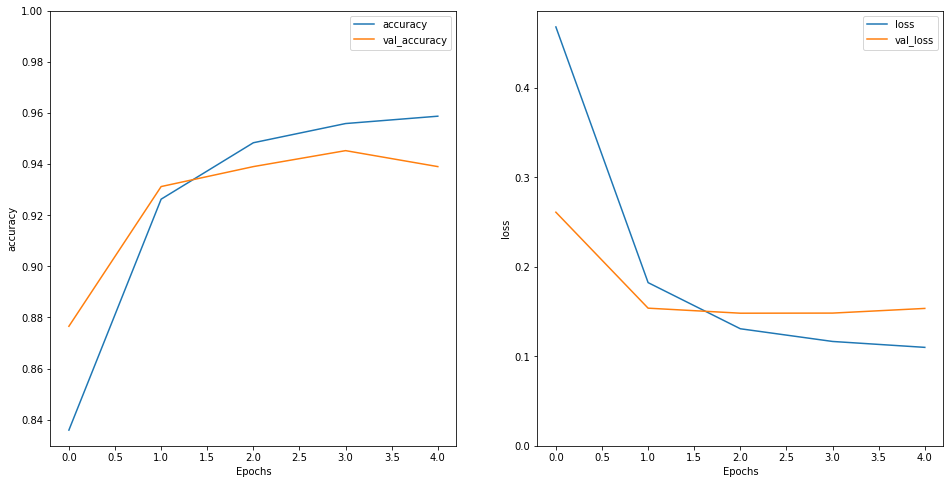

In [21]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [22]:
sample_text = ['That was very nice of you to say', 'You stupid fucking bitch']
predictions = model.predict(np.array(sample_text))
print(predictions)

[[0.783 0.217]
 [0.    1.   ]]


## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional](images/layered_bidirectional.png)

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

In [23]:
model_two = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax')
])

print(model_two.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, None, 64)          64000     
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 128)        66048     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                      

In [24]:
model_two.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics=['accuracy'])

In [25]:
history_two = model_two.fit(train_dataset, epochs=5,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/5
310/310 [==============================] - 13s 22ms/step - loss: 0.4666 - accuracy: 0.8385 - f1_score: 0.8385 - val_loss: 0.2537 - val_accuracy: 0.8849 - val_f1_score: 0.8849
Epoch 2/5
310/310 [==============================] - 4s 13ms/step - loss: 0.1854 - accuracy: 0.9258 - f1_score: 0.9258 - val_loss: 0.1534 - val_accuracy: 0.9396 - val_f1_score: 0.9396
Epoch 3/5
310/310 [==============================] - 4s 13ms/step - loss: 0.1338 - accuracy: 0.9493 - f1_score: 0.9493 - val_loss: 0.1465 - val_accuracy: 0.9427 - val_f1_score: 0.9427
Epoch 4/5
310/310 [==============================] - 4s 13ms/step - loss: 0.1198 - accuracy: 0.9563 - f1_score: 0.9563 - val_loss: 0.1449 - val_accuracy: 0.9443 - val_f1_score: 0.9443
Epoch 5/5
310/310 [==============================] - 4s 13ms/step - loss: 0.1119 - accuracy: 0.9604 - f1_score: 0.9604 - val_loss: 0.1434 - val_accuracy: 0.9443 - val_f1_score: 0.9443


In [26]:
test_loss, test_acc, test_entr = model_two.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)
print('Test Entropy:', test_entr)

78/78 [==============================] - 0s 5ms/step - loss: 0.1388 - accuracy: 0.9429 - f1_score: 0.9429
Test Loss: 0.1388106644153595
Test Accuracy: 0.9429090023040771
Test Entropy: 0.9429090023040771


In [27]:
# predict on a sample text without padding.

sample_text = ['You are such a stupid fucking whore',
               'I would not recommend this movie.']
predictions = model_two.predict(np.array(sample_text))

print(predictions)

[[0.    1.   ]
 [0.706 0.294]]


In [28]:
# Save the model
!mkdir models
model_two.save('models/rnn_two')

Der Befehl "mkdirl" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.


INFO:tensorflow:Assets written to: models/rnn_two\assets


INFO:tensorflow:Assets written to: models/rnn_two\assets


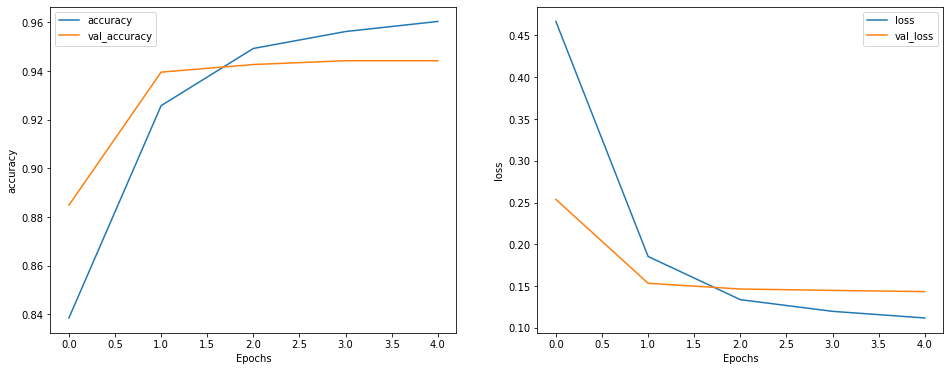

In [29]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history_two, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history_two, 'loss')

Check out other existing recurrent layers such as [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).

If you're interestied in building custom RNNs, see the [Keras RNN Guide](https://www.tensorflow.org/guide/keras/rnn).
